Predicting GRFs from EMG data (quincy working on this please dont edit yet. only cleaned up code goes here)

Things I'd like to add
- how can we run this using google computers to make it go faster
- how can we do SGD so an epoch doesn't take as long
- how can we incorporate holdout so we actually have test and training sets

In [15]:
from google.colab import drive
drive.mount('/content/drive')

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision.utils import make_grid

from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tabulate import tabulate
import ast
import os
import time
import math
import yaml
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset

In [48]:
# %cd /content/drive/Shareddrives/485Final/WalkingData


# #so we need test, train, val for right and left for rf of 1 and 16
# e, g, n, l = detatched_load_data(1, 40, ['ben', 'cooper', 'quincy'], 0, 0, 120000)
# data_train = EMG_GRF_Dataset_simple('righty', 50, 2000, 1, e, g, n, l)
# e, g, n, l = detatched_load_data(1, 40, ['ben', 'cooper', 'quincy'], 120000, 160000)
# data_val = EMG_GRF_Dataset_simple('righty', 50, 2000, 1, e, g, n, l)
# e, g, n, l = detatched_load_data(1, 40, ['ben', 'cooper', 'quincy'], 0, 160000, 200000)
# data_test = EMG_GRF_Dataset_simple('righty', 50, 2000, 1, e, g, n, l)

# e, g, n, l = detatched_load_data(1, 40, ['ben', 'cooper', 'quincy'], 0, 0, 120000)
# data_train_left = EMG_GRF_Dataset_simple('lefty', 50, 2000, 1, e, g, n, l)
# e, g, n, l = detatched_load_data(1, 40, ['ben', 'cooper', 'quincy'], 120000, 160000)
# data_val_left = EMG_GRF_Dataset_simple('lefty', 50, 2000, 1, e, g, n, l)
# e, g, n, l = detatched_load_data(1, 40, ['ben', 'cooper', 'quincy'], 0, 160000, 200000)
# data_test_left = EMG_GRF_Dataset_simple('lefty', 50, 2000, 1, e, g, n, l)

# e, g, n, l = detatched_load_data(16, 40, ['ben', 'cooper', 'quincy'], 0, 0, 120000)
# data_train_rf = EMG_GRF_Dataset_simple('righty', 50, 2000, 16, e, g, n, l)
# e, g, n, l = detatched_load_data(16, 40, ['ben', 'cooper', 'quincy'], 120000, 160000)
# data_val_rf = EMG_GRF_Dataset_simple('righty', 50, 2000, 16, e, g, n, l)
# e, g, n, l = detatched_load_data(16, 40, ['ben', 'cooper', 'quincy'], 0, 160000, 200000)
# data_test_rf = EMG_GRF_Dataset_simple('righty', 50, 2000, 16, e, g, n, l)

# e, g, n, l = detatched_load_data(16, 40, ['ben', 'cooper', 'quincy'], 0, 0, 120000)
# data_train_rf_left = EMG_GRF_Dataset_simple('lefty', 50, 2000, 16, e, g, n, l)
# e, g, n, l = detatched_load_data(16, 40, ['ben', 'cooper', 'quincy'], 120000, 160000)
# data_val_rf_left = EMG_GRF_Dataset_simple('lefty', 50, 2000, 16, e, g, n, l)
# e, g, n, l = detatched_load_data(16, 40, ['ben', 'cooper', 'quincy'], 0, 160000, 200000)
# data_test_rf_left = EMG_GRF_Dataset_simple('lefty', 50, 2000, 16, e, g, n, l)



# data_val = data_train
# data_val_rf = data_train_rf

# data_train_left = data_train
# data_train_rf_left = data_train_rf

# data_val_left = data_train
# data_val_rf_left = data_train_rf

# So now we need to load data separately... 
# we should load up all the data?


# load data needs to knoe what files to load

In [49]:
#output_type in {righty, lefty, sumy}
names = ['cooper', 'ben', 'quincy']
# names = ['cooper']

class EMG_GRF_Dataset_Splits(Dataset):
  def __init__(self, output_type, emg_sr, grf_sr, receptive_field, center_field=False):
    self.output_type = output_type
    self.emg_sr = emg_sr
    self.grf_sr = grf_sr
    self.sr_ratio = self.grf_sr / self.emg_sr
    self.receptive_field = receptive_field
    self.center_field = center_field

    #required
    self.grf_cols_to_use = ['time', 'R_ground_force_vz', 'L_ground_force_vz']

    #filled in with loaded data
    self.grfs = []
    self.emgs = []
    self.truenumdatapoints = []
    self.length = 0

    #to do splitting
    self.numdatapoints = []
    self.offsets = []
    
    self.load_data()

  def get_num_files(self):
    return len(self.numdatapoints)

  def set_limits(self, file_offsets, file_counts):
    self.length = 0
    for i, (o, c) in enumerate(zip(file_offsets, file_counts)):
      if(o + c > self.truenumdatapoints[i]):
        c = max(0, self.truenumdatapoints[i] - o)

      self.numdatapoints[i] = c
      self.offsets[i] = o
      self.length += c

  def set_output_type(self, ot):
    self.output_type = ot

  def reset_limits(self):
    self.length = 0
    for i in range(len(self.numdatapoints)):
      self.numdatapoints[i] = self.trunumdatapoints[i]
      self.offsets[i] = 0
      self.length += self.numdatapoints[-1]

  def __len__(self):
    return self.length

  def load_data(self):
    for name in names:
      height = 0
      mass = 0

      # open a single subject to get heigh and mass
      with open(name+'/sessionMetadata.yaml') as metadata:
        data_loaded = yaml.safe_load(metadata)
        height = data_loaded['height_m'] / 4
        mass = data_loaded['mass_kg'] / 200

      emg_df=pd.read_csv(name+'/EMGData/LongWalkEMG.sto', sep='\t',header=0,skiprows=4)
      grf_df=pd.read_csv(name+'/ForceData/LongWalkForces.mot', sep='\t',header=0,skiprows=6)

      grf_df = grf_df[self.grf_cols_to_use]

      mask = (grf_df.iloc[:, 1:] != 0).any(axis=1)
      first_non_zero_index = mask.idxmax()
      last_non_zero_index = mask[::-1].idxmax()

      shifted_first_nonzero_index = first_non_zero_index + (self.sr_ratio - (first_non_zero_index % self.sr_ratio))
      shifted_last_nonzero_index = last_non_zero_index - (last_non_zero_index % self.sr_ratio)

      grf_df = grf_df.loc[shifted_first_nonzero_index:shifted_last_nonzero_index-1]

      first_nonzero_emg = (shifted_first_nonzero_index / self.sr_ratio)
      last_nonzero_emg = (shifted_last_nonzero_index / self.sr_ratio)

      emg_df = emg_df.loc[first_nonzero_emg:last_nonzero_emg-1]
      emg_df['height'] = height
      emg_df['mass'] = mass

      emg_df.drop('time', axis=1, inplace=True)  
      grf_df.drop('time', axis=1, inplace=True)      

      self.grfs.append(grf_df)
      self.emgs.append(emg_df)
      self.numdatapoints.append(int((emg_df.shape[0]-self.receptive_field) * self.sr_ratio))
      self.truenumdatapoints.append(self.numdatapoints[-1])
      self.offsets.append(0)
      self.length += self.numdatapoints[-1]

  def __getitem__(self, index):
    file_index = 0
    while(index >= self.numdatapoints[file_index]):
      index -= self.numdatapoints[file_index]
      file_index += 1

    index += self.offsets[file_index]

    grf = self.grfs[file_index]
    if(self.center_field):
      grf_loc = int(index + (self.sr_ratio * self.receptive_field / 2.0))
    else:
      grf_loc = int(index + (self.sr_ratio * self.receptive_field))
     
    emg_start = int(math.floor(index/self.sr_ratio))
    emg_end = int(emg_start + self.receptive_field)

    emg_data = self.emgs[file_index].iloc[emg_start:emg_end].to_numpy()
    grf_data = self.grfs[file_index].iloc[grf_loc].to_numpy()
    gt = self.get_output(grf_data) / 1000.0
    
    return emg_data, gt
  
  def get_output(self, data):
    if(self.output_type == 'righty'):
      return data[0]
    elif(self.output_type == 'lefty'):
      return data[1]
    elif(self.output_type == 'sumy'):
      return (data[0] + data[1])
    else:
      return data

In [46]:
%cd /content/drive/Shareddrives/485Final/WalkingData

# data = EMG_GRF_Dataset_Splits('righty', 50, 2000, 1)
# data_rf = EMG_GRF_Dataset_Splits('righty', 50, 2000, 16)

# left_data = EMG_GRF_Dataset_Splits('lefty', 50, 2000, 1)
# left_data_rf = EMG_GRF_Dataset_Splits('lefty', 50, 2000, 16)

/content/drive/Shareddrives/485Final/WalkingData


(array([[0.091757, 0.007145, 0.369393, 0.20576 , 0.085835, 0.056648,
         0.374315, 0.116784, 0.065259, 0.003366, 0.023661, 0.041008,
         0.086113, 0.02954 , 0.4625  , 0.375   ]]),
 0.0)

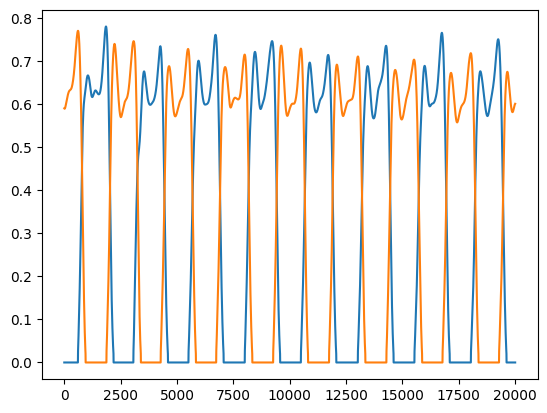

In [47]:
gt = []
gtl = []
for i in range(20000):
  gt.append(data.__getitem__(i)[1])

data.set_output_type('lefty')
for i in range(20000):
  gtl.append(data.__getitem__(i)[1])

plt.plot(range(20000),gt)
plt.plot(range(20000),gtl)
plt.show()


Models

In [50]:
#Deep Linear Model
class DeepLinearModel(nn.Module):
  def __init__(self,
               sensor_array_size=16,
               dtype=torch.FloatTensor):
    
    super(DeepLinearModel, self).__init__()

    self.sensor_count = sensor_array_size
    self.dtype = dtype

    self.linear_layers = nn.ModuleList()

    self.setup_model()

  def setup_model(self):
    self.linear_layers.append(nn.Linear(self.sensor_count,128))
    self.linear_layers.append(nn.Linear(128,64))
    self.linear_layers.append(nn.Linear(64,32))
    self.linear_layers.append(nn.Linear(32,16))
    self.linear_layers.append(nn.Linear(16,1))
    
  def forward(self, input, printing=False):
    for l in self.linear_layers:
      input = F.relu(l(input))

    return input

In [51]:
#Linear Model
class LinearModel(nn.Module):
  def __init__(self,
               sensor_array_size=16,
               dtype=torch.FloatTensor):
    
    super(LinearModel, self).__init__()

    self.sensor_count = sensor_array_size
    self.dtype = dtype

    self.layers = nn.ModuleList()

    self.setup_model()

  def setup_model(self):
    self.layers.append(nn.Linear(self.sensor_count,1))
    
  def forward(self, input, printing=False):
    return F.relu(self.layers[0](input))

In [52]:
#Wavent
class WavenetModel(nn.Module):
  def __init__(self,
               sensor_array_size=16,
               receptive_field=16,
               dtype=torch.FloatTensor,
               bias=False):
    
    super(WavenetModel, self).__init__()

    self.sensor_count = sensor_array_size
    self.receptive_field = receptive_field #this needs to be a power of 2 (ie: 2, 4, 8, 16, 32, 64)
    self.layers = int(math.log2(receptive_field))
    self.bias = bias
    self.dtype = dtype

    self.filter_convs = nn.ModuleList()
    self.gate_convs = nn.ModuleList()

    self.setup_model()

  def setup_model(self):
    for l in range(self.layers):
      width = math.pow(2,self.layers-l)
      height = width
      kernel = (2,2)
      
      #this needs to handle the case when sensor count is not a power of 2
      # if(l == 0):
      #   height = self.receptive_field
      #   kernel = (2,4) #this needs to be something...

      self.filter_convs.append(nn.Conv2d(in_channels=1,
                                          out_channels=1,
                                          kernel_size = kernel,
                                          stride=2,
                                          bias=self.bias))
      
      self.gate_convs.append(nn.Conv2d(in_channels=1,
                                          out_channels=1,
                                          kernel_size = kernel,
                                          stride=2,
                                          bias=self.bias))
    
  def forward(self, input, printing=False):
    x = input
    
    for i in range(self.layers):
      filt = self.filter_convs[i](x)
      filt = F.tanh(filt)
      gate = self.gate_convs[i](x)
      gate = F.sigmoid(gate)
      x = filt * gate
        
    x = F.relu(x)
    return x

In [53]:
#Echo State Network

Trainer

In [54]:
class Trainer():
  def __init__(self,
              model,
              dataset,
              lr=0.001,
              small_set=False,
              gradient_clipping=None):
    

    self.lr = lr
    self.model = model
    self.dataset = dataset
    self.small_set = small_set
    self.clip = gradient_clipping
    self.optimizer = torch.optim.Adam(self.model.parameters(),lr=self.lr)

    self.learning_curve = []


  def viz_at_epoch(self):
    gt = []
    pred = []
    for i in range(self.dataset.__len__()):
      if(i < 5000):
        continue

      if(i > 10000):
        break
      
      e, g = self.dataset.__getitem__(i)
      e = torch.tensor(e).type(torch.FloatTensor)
      g = torch.tensor(g).type(torch.FloatTensor)
      e = e.unsqueeze(0)

      o = self.model(e)
      gt.append(g.item())
      pred.append(o.item())

    plt.plot(range(len(gt)),gt,label='ground truth')
    plt.plot(range(len(pred)),pred, label='predictions')
    plt.legend()
    plt.show()

  def train(self, batch_size=32, epochs=2):    
    #put in training mode
    self.model.train()
    self.dataloader = torch.utils.data.DataLoader(self.dataset,
                                                      batch_size=batch_size,
                                                      shuffle=False,
                                                      num_workers=2,
                                                      pin_memory=False)
    

    #get initial cost
    cost = 0
    for i, (x, t) in enumerate(iter(self.dataloader)):
      if(i > 1000):
      # if(i > 1000 and self.small_set):
        break

      x = x.type(torch.FloatTensor)
      t = t.type(torch.FloatTensor)
      x = x.unsqueeze(1)

      if(t.sum() == 0 and random.random() > 0.001):
        continue

      o = self.model(x).flatten()
      
      loss = F.mse_loss(o,t)
      cost += loss.item()
    self.learning_curve.append(cost)


    #shuffling might not work because of the way we look for 'zero' points... be wary of changing that to true
    print('we are going to train on ' + str(len(self.dataset.numdatapoints)) + ' files with a total of ' + str(self.dataset.__len__()) + ' datapoints.')
    
    # self.viz_at_epoch()
    for e in range(epochs):
        cost = 0
        for i, (x, t) in enumerate(iter(self.dataloader)):
          # if(i > 1000 and self.small_set):
          if(i > 1000):
            break

          x = x.type(torch.FloatTensor)
          t = t.type(torch.FloatTensor)
          x = x.unsqueeze(1)

          if(t.sum() == 0 and random.random() > 0.001):
            continue
  
          o = self.model(x).flatten()
          
          loss = F.mse_loss(o,t)
          self.optimizer.zero_grad()
          loss.backward()
          cost += loss.item()
          self.optimizer.step();
  
          #potentially useful ways to improve
          # if self.clip is not None:
          #     torch.nn.utils.clip_grad_norm(self.model.parameters(), self.clip)

        # self.viz_at_epoch()

  
        print(f"Epoch {e}: traing loss: {cost}")
        self.learning_curve.append(cost)

Running and Plotting

In [55]:
%cd /content/drive/Shareddrives/485Final/WalkingData

data = EMG_GRF_Dataset_Splits('righty', 50, 2000, 1)
data_rf = EMG_GRF_Dataset_Splits('righty', 50, 2000, 16)

# left_data = EMG_GRF_Dataset_Splits('lefty', 50, 2000, 1)
# left_data_rf = EMG_GRF_Dataset_Splits('lefty', 50, 2000, 16)

/content/drive/Shareddrives/485Final/WalkingData


In [25]:
train_starts = [0,0,0]
train_counts = [120000,120000,120000]

val_starts = [120000,120000,120000]
val_counts = [40000,40000,40000]

test_starts = [160000,160000,160000]
test_counts = [40000,40000,40000]

gen_train_starts = [0,0,0]
gen_train_counts = [200000,200000,0]

gen_val_starts = [0,0,0]
gen_val_counts = [0,0,100000]

gen_test_starts = [0,0,100000]
gen_test_counts = [0,0,100000]

In [27]:
data.set_limits(train_starts, train_counts)
data_rf.set_limits(train_starts, train_counts)
# left_data.set_limits(train_starts, train_counts)
# left_data_rf.set_limits(train_starts, train_counts)

lin_even_split = LinearModel()
deeplin_even_split = DeepLinearModel()
wavenet_even_split = WavenetModel()

lin_even_trainer = Trainer(lin_even_split, data)
deeplin_even_trainer = Trainer(deeplin_even_split, data)
wavenet_even_trainer = Trainer(wavenet_even_split, data_rf)

lin_even_trainer.train()
deeplin_even_trainer.train()
wavenet_even_trainer.train()

we are going to train on 3 files with a total of 360000 datapoints.
Epoch 0: traing loss: 57.00578542416042
Epoch 1: traing loss: 29.236373498140892
we are going to train on 3 files with a total of 360000 datapoints.
Epoch 0: traing loss: 202.37025033266218
Epoch 1: traing loss: 202.37025033266218
we are going to train on 3 files with a total of 5991840 datapoints.
Epoch 0: traing loss: 117.74518304492813
Epoch 1: traing loss: 32.07040573008635


In [28]:
data.set_output_type('lefty')
data_rf.set_output_type('lefty')

left_lin_even_split = LinearModel()
left_deeplin_even_split = DeepLinearModel()
left_wavenet_even_split = WavenetModel()

left_lin_even_trainer = Trainer(left_lin_even_split, data)
left_deeplin_even_trainer = Trainer(left_deeplin_even_split, data)
left_wavenet_even_trainer = Trainer(left_wavenet_even_split, data_rf)

left_lin_even_trainer.train()
left_deeplin_even_trainer.train()
left_wavenet_even_trainer.train()

we are going to train on 3 files with a total of 360000 datapoints.
Epoch 0: traing loss: 45.948175810452085
Epoch 1: traing loss: 17.01233795345098
we are going to train on 3 files with a total of 360000 datapoints.
Epoch 0: traing loss: 200.6936974505952
Epoch 1: traing loss: 200.6936974505952
we are going to train on 3 files with a total of 5991840 datapoints.
Epoch 0: traing loss: 90.13321648883357
Epoch 1: traing loss: 29.79358526308897


In [29]:
data.set_limits(gen_train_starts, gen_train_counts)
data_rf.set_limits(gen_train_starts, gen_train_counts)

left_lin_generalizer = LinearModel()
left_deeplin_generalizer = DeepLinearModel()
left_wavenet_generalizer = WavenetModel()

left_lin_generalized_trainer = Trainer(left_lin_generalizer, data)
left_deeplin_generalized_trainer = Trainer(left_deeplin_generalizer, data)
left_wavenet_generalized_trainer = Trainer(left_wavenet_generalizer, data_rf)

left_lin_generalized_trainer.train()
left_deeplin_generalized_trainer.train()
left_wavenet_generalized_trainer.train()

we are going to train on 3 files with a total of 400000 datapoints.
Epoch 0: traing loss: 40.85127954080235
Epoch 1: traing loss: 18.125186771885637
we are going to train on 3 files with a total of 400000 datapoints.
Epoch 0: traing loss: 200.6936974505952
Epoch 1: traing loss: 200.6936974505952
we are going to train on 3 files with a total of 400000 datapoints.
Epoch 0: traing loss: 129.01059753323443
Epoch 1: traing loss: 35.9362401080416


In [30]:
data.set_output_type('righty')
data_rf.set_output_type('righty')

lin_generalizer = LinearModel()
deeplin_generalizer = DeepLinearModel()
wavenet_generalizer = WavenetModel()

lin_generalized_trainer = Trainer(lin_generalizer, data)
deeplin_generalized_trainer = Trainer(deeplin_generalizer, data)
wavenet_generalized_trainer = Trainer(wavenet_generalizer, data_rf)

lin_generalized_trainer.train()
deeplin_generalized_trainer.train()
wavenet_generalized_trainer.train()

we are going to train on 3 files with a total of 400000 datapoints.
Epoch 0: traing loss: 202.37025033266218
Epoch 1: traing loss: 202.37025033266218
we are going to train on 3 files with a total of 400000 datapoints.
Epoch 0: traing loss: 202.37025033266218
Epoch 1: traing loss: 202.37025033266218
we are going to train on 3 files with a total of 400000 datapoints.
Epoch 0: traing loss: 100.33208512891724
Epoch 1: traing loss: 31.65878759398971


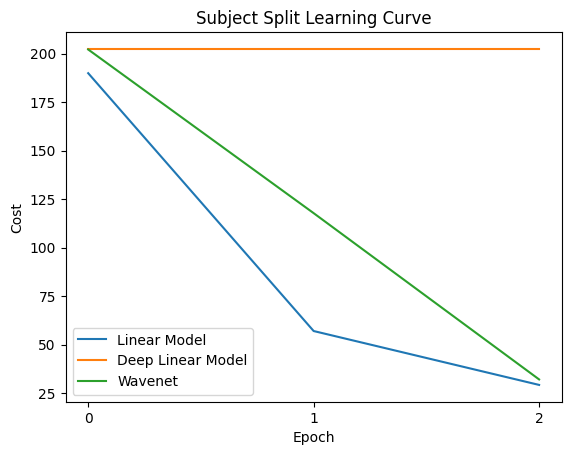

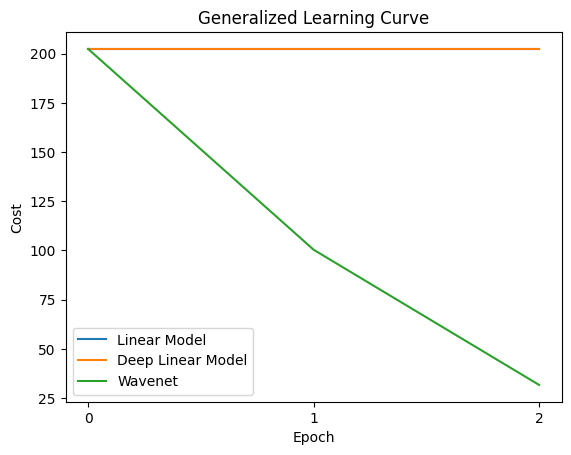

In [31]:
#plot learning curves together
#add in legends and colors and axis labels and a title
plt.plot(range(3),lin_even_trainer.learning_curve,label='Linear Model')
plt.plot(range(3),deeplin_even_trainer.learning_curve,label='Deep Linear Model')
plt.plot(range(3),wavenet_even_trainer.learning_curve,label='Wavenet')
plt.title('Subject Split Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.xticks(range(0,3))
plt.legend()
plt.show()

plt.plot(range(3),lin_generalized_trainer.learning_curve,label='Linear Model')
plt.plot(range(3),deeplin_generalized_trainer.learning_curve,label='Deep Linear Model')
plt.plot(range(3),wavenet_generalized_trainer.learning_curve,label='Wavenet')
plt.title('Generalized Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.xticks(range(0,3))
plt.legend()
plt.show()

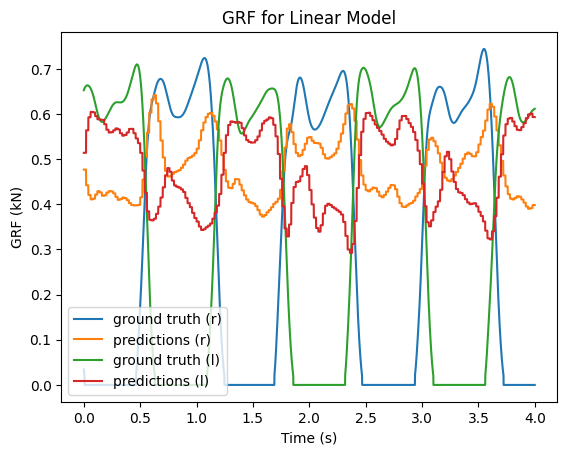

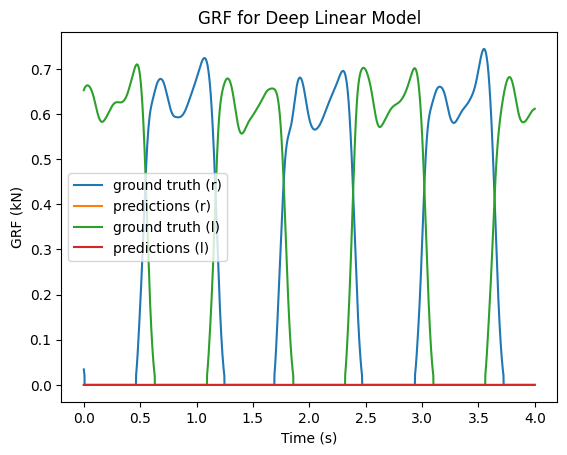

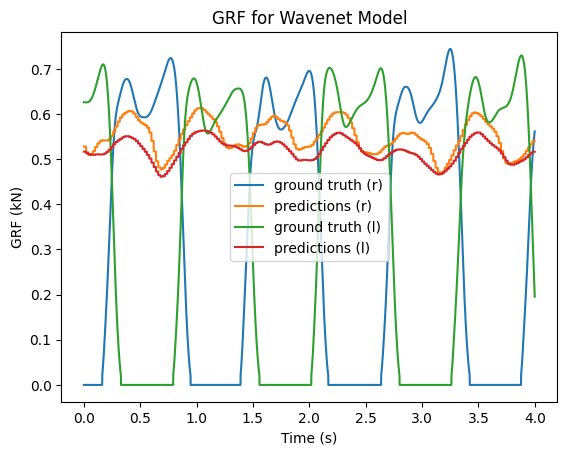

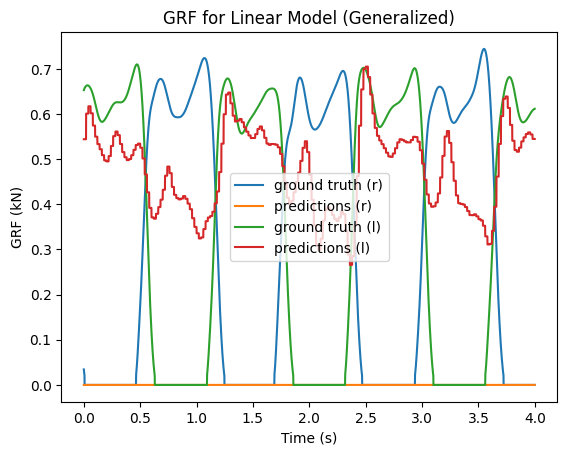

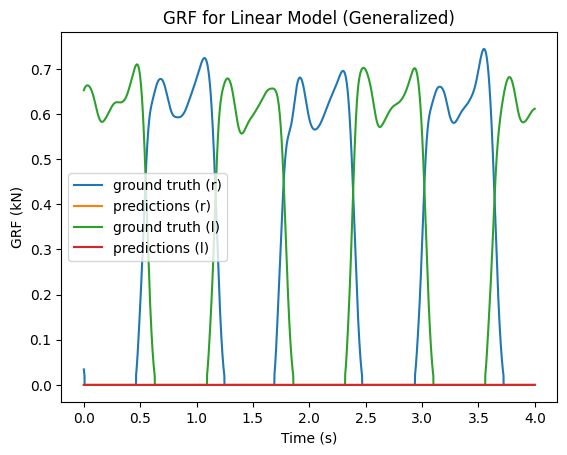

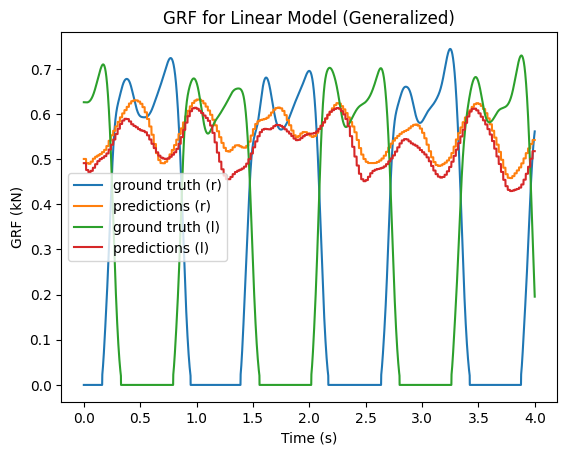

In [56]:
#plot predictions together
def plot_preds(model, dataset, model_left, title):
  gt = []
  pred = []
  gt_l = []
  pred_l = []
  for i in range(dataset.__len__()):
    if(i < 10000):
      continue

    if(i >= 18000):
      break
    
    dataset.set_output_type('righty')
    e, g = dataset.__getitem__(i)
    dataset.set_output_type('lefty')
    e_l, g_l = dataset.__getitem__(i)
    e = torch.tensor(e).type(torch.FloatTensor)
    g = torch.tensor(g).type(torch.FloatTensor)
    e = e.unsqueeze(0)

    o = model(e)
    o_l = model_left(e)
    gt.append(g.item())
    gt_l.append(g_l.item())
    pred.append(o.item())
    pred_l.append(o_l.item())

  xvals = [i for i in np.arange(0, 4, 0.0005)] 
  plt.plot(xvals,gt,label='ground truth (r)')
  plt.plot(xvals,pred, label='predictions (r)')

  plt.plot(xvals,gt_l,label='ground truth (l)')
  plt.plot(xvals,pred_l, label='predictions (l)')
  plt.legend()
  plt.ylabel('GRF (kN)')
  plt.xlabel('Time (s)')
  plt.title(title)
  plt.show()

data.set_output_type('righty')
data_rf.set_output_type('righty')

data.set_limits(val_starts, val_counts)
data_rf.set_limits(val_starts, val_counts)
# left_data.set_limits(val_starts, val_counts)
# left_data_rf.set_limits(val_starts, val_counts)

plot_preds(lin_even_split, data, left_lin_even_split, 'GRF for Linear Model')
plot_preds(deeplin_even_split, data, left_deeplin_even_split, 'GRF for Deep Linear Model')
plot_preds(wavenet_even_split, data_rf, left_wavenet_even_split, 'GRF for Wavenet Model')

# data.set_output_type('lefty')
# data_rf.set_output_type('lefty')

plot_preds(lin_generalizer, data, left_lin_generalizer, 'GRF for Linear Model (Generalized)')
plot_preds(deeplin_generalizer, data, left_deeplin_generalizer, 'GRF for Deep Linear Model (Generalized)')
plot_preds(wavenet_generalizer, data_rf, left_wavenet_generalizer, 'GRF for Wavenet Model (Generalized)')

In [61]:
#timing
import time

def measure_run(model, data, statement):
  print('timing ' + statement)
  start_time = time.perf_counter()

  for i in range(10000):
    e, g = data.__getitem__(i)
    e = torch.tensor(e).type(torch.FloatTensor)
    g = torch.tensor(g).type(torch.FloatTensor)
    e = e.unsqueeze(0)

    o = model(e)

  end_time = time.perf_counter()
  elapsed_time = end_time - start_time
  print("Elapsed time: ", elapsed_time)


measure_run(lin_even_split, data, 'linear model')
measure_run(deeplin_even_split, data, 'deep linear model')
measure_run(wavenet_even_split, data_rf, 'wavenet')
measure_run(left_lin_even_split, data, 'linear model')
measure_run(left_deeplin_even_split, data, 'depe linear model')
measure_run(left_wavenet_even_split, data_rf, 'wavenet')


measure_run(lin_generalizer, data, 'linear model')
measure_run(deeplin_generalizer, data, 'deep linear model')
measure_run(wavenet_generalizer, data_rf, 'wavenet')
measure_run(left_lin_generalizer, data, 'linear model')
measure_run(left_deeplin_generalizer, data, 'deep linear model')
measure_run(left_wavenet_generalizer, data_rf, 'wawvenet')

timing linear model
Elapsed time:  4.313784022000618
timing deep linear model
Elapsed time:  6.493302754999604
timing wavenet
Elapsed time:  7.8812914219997765
timing linear model
Elapsed time:  4.875857224000356
timing depe linear model
Elapsed time:  6.355352204000155
timing wavenet
Elapsed time:  9.04286189999948
timing linear model
Elapsed time:  4.893646213000466
timing deep linear model
Elapsed time:  6.205118581998249
timing wavenet
Elapsed time:  8.441592604000107
timing linear model
Elapsed time:  4.180446637999921
timing deep linear model
Elapsed time:  6.218365164000716
timing wawvenet
Elapsed time:  8.73673430999952


In [57]:
#make tables for stuff



even_split_table = [['Model Type', 'Final Epoch Error', 'Training time '], 
                    ['Simple Linear', 1000, 0.5], 
                    ['Deep Linear', 24, 1], 
                    ['Wavenet', 100, 4]]

generalized_table = [['Model Type', 'Final Epoch Error', 'Training time '], 
                    ['Simple Linear', 1000, 0.5], 
                    ['Deep Linear', 24, 1], 
                    ['Wavenet', 100, 4]]

print(tabulate(even_split_table, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate(generalized_table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════╤═════════════════════╤══════════════════╕
│ Model Type    │   Final Epoch Error │   Training time  │
╞═══════════════╪═════════════════════╪══════════════════╡
│ Simple Linear │                1000 │              0.5 │
├───────────────┼─────────────────────┼──────────────────┤
│ Deep Linear   │                  24 │              1   │
├───────────────┼─────────────────────┼──────────────────┤
│ Wavenet       │                 100 │              4   │
╘═══════════════╧═════════════════════╧══════════════════╛
╒═══════════════╤═════════════════════╤══════════════════╕
│ Model Type    │   Final Epoch Error │   Training time  │
╞═══════════════╪═════════════════════╪══════════════════╡
│ Simple Linear │                1000 │              0.5 │
├───────────────┼─────────────────────┼──────────────────┤
│ Deep Linear   │                  24 │              1   │
├───────────────┼─────────────────────┼──────────────────┤
│ Wavenet       │                 100 │              4  